<a href="https://colab.research.google.com/github/tomiambro/ap_automatico/blob/tps-tomi/tp2pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, tensor, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

import itertools

## Configuracion

Seteamos el dispositivo

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Cambiar el path para que coincida con el drive personal

In [4]:
root_path = 'gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset'  #change dir to your project folder

## Cargamos y exploramos el dataset

Levantamos la ruta de imagenes dentro de un objeto Path para poder iterar y leerlas

In [5]:
from pathlib import Path
imgs_path = Path(f'{root_path}/images/Images')

Inspeccionamos un poco el dataset

Definimos las razas de perro que nos interesa identificar.

In [6]:
classes_path = [c for c in imgs_path.iterdir() if c.is_dir()]
custom_classes = ['Australian_terrier', 'Border_terrier', 'Samoyed', 'beagle', 'Shih-Tzu', 'English_foxhound', 'Rhodesian_ridgeback', 'dingo', 'golden_retriever', 'Old_English_sheepdog']

cl = sorted(str(c) for c in classes_path)

labels = [str(c.stem) for c in sorted(imgs_path.glob('*'))]
idx = []

for t in custom_classes:
  for c in labels:
    if t in c:
      idx.append(labels.index(c))

target_classes = [labels[x] for x in idx]
len(target_classes)

10

In [7]:
all_paths = [c for c in sorted(imgs_path.glob('*'))]

idx = []

for t in custom_classes:
  for c in all_paths:
    if t in str(c):
      idx.append(all_paths.index(c))

paths = [all_paths[x] for x in idx]
f = []
aux = []
aux = [imgs_path.glob(f'{str(paths[i].stem)}/*') for i in range(len(paths))]

for i in itertools.chain(*aux):
  f.append(i)

paths

[PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02096294-Australian_terrier'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02093754-Border_terrier'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02111889-Samoyed'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02088364-beagle'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02086240-Shih-Tzu'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02089973-English_foxhound'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02087394-Rhodesian_ridgeback'),
 PosixPath('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02115641-dingo'),
 PosixPath('gdrive/MyDrive/machine_learning

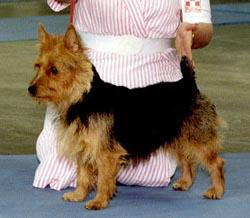

In [8]:
perro = [img for img in paths[0].iterdir()]
Image.open(perro[0])

Hay una imagen que no sabemos porque figura tener cuatro canales: .shape = [4, H, W] asi que la eliminamos del dataset.

El codigo queda comentado porq cargar todas las imagenes en memoria consume demasiada RAM. Solo en necesario correr el bloque una vez.

In [9]:
# HAY UNA IMAGEN QUE VIENE CON 4 CANALES Y ROMPE TODO. CON ESTA CELDA SE ELIMINA PARA PODER ENTRENAR BIEN.


# imgs = [read_image(str(img)).to(device) for img in f]
# for i, img in enumerate(imgs):
#  if img.shape[0] == 4:
#    print(img.shape)
#    print('La encontre!', i)
#    print(f'Eliminando: {f[i]}')
#    f[i].unlink()

Creamos una clase que nos permita cargar las imagenes y pasarselas a pytorch segun su documentación.

(En esta celda está parte de la magia)

In [10]:
class CustomImageDataset(Dataset):
  def __init__(self, imgs_dir, target_classes, transform=None):
    idx = []
    f = []
    aux = []

    self.imgs_dir = Path(imgs_dir)
    self.transform = transform
    all_paths = [c for c in sorted(imgs_path.glob('*'))]

    for t in target_classes:
      for c in all_paths:
        if t in str(c):
          idx.append(all_paths.index(c))
   
    aux = [imgs_path.glob(f'{str(paths[i].stem)}/*') for i in range(len(paths))]

    for i in itertools.chain(*aux):
      f.append(i)
    self.f = f
    
    self.labels = [str(all_paths[x].stem) for x in idx]
    self.le = preprocessing.LabelEncoder()
    self.le.fit(self.labels)

  def __len__(self):
    return len(self.f)

  def __getitem__(self, idx):
    image = read_image(str(self.f[idx]))
    label = str(self.f[idx].parents[0].stem).split('/')[-1]
    if self.transform:
      image = self.transform(image)
    return image, int(self.le.transform([label]))
  
  def get_label(self, y):
    return self.le.inverse_transform(y.reshape(-1))[0]

Como todas las imagenes tiene un aspect ration distinto, las transformamos para que todas tengan el mismo tamaño (256 x 256) y cargamos los datos usando *CustomImageDataset* y pasandole las transformaciones que definimos antes.

In [11]:
t = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ConvertImageDtype(torch.float),
])

data = CustomImageDataset(f'{root_path}/images/Images', custom_classes, transform=t)

Chequeamos las proporciones de nuestro train y validation set. Como se puede ver son muy pocas imagenes.

In [12]:
train_size, valid_size = round(len(data)*.8), round(len(data)*.2)

train_size, valid_size

(1439, 360)

Al igual que con sklearn, hacemos un split para partir el dataset en train y test

In [13]:
from torch.utils.data import random_split

train, test = random_split(data, [train_size, valid_size], generator=torch.Generator().manual_seed(42))

Definimos nuestros Dataloaders que son los que va a usar el modelo para iterar en batches. Definimos el batch size en 128.

In [14]:
bs = 128

train_dataloader = DataLoader(train, batch_size=bs, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
test_dataloader = DataLoader(test, batch_size=bs, shuffle=False, num_workers=2, pin_memory=True, persistent_workers=True)

Hacemos una iteracion de prueba sobre el train dataloader para verificar que podemos ver las imagenes y recibimos bien las labels.

In [15]:
%time train_features, train_labels = next(iter(train_dataloader))

CPU times: user 2.2 s, sys: 1.08 s, total: 3.29 s
Wall time: 5.72 s


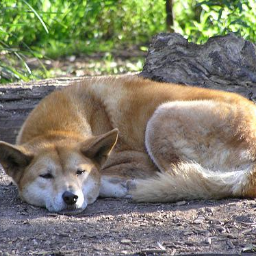

In [16]:
trans = transforms.ToPILImage()
trans(train_features[0])

In [17]:
print(f"Label: {data.get_label(train_labels[0])}")

Label: n02115641-dingo


## El modelo

Definimos nuestro modelo segun la documentacion de pytorch


(Si vemos el summary, de primera Linear layer pasa de 59536 neuronas a 120, tal vez conviene agregar una layer intermedia que baje la cant a un numero mas chico antes de pasar a 120.)

In [18]:
n_classes = 10

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        # ho = 252
        self.pool = nn.MaxPool2d(2, 2)
        # ho, wo = 126
        self.conv2 = nn.Conv2d(6, 16, 5)
        # ho, wo = 122
        # MaxPool
        # ho, wo = 61
        self.fc1 = nn.Linear(16 * 61 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN()
model = model.to(device, non_blocking=True)

Definimos nuestra funcion de perdida como Cross Entropy Loss y nuestro optimizador SGD

In [19]:
lr = 0.01
params = [p for p in model.parameters() if p.requires_grad]
loss_f = nn.CrossEntropyLoss()
optimizer = optim.SGD(params, lr=lr, momentum=0.9)
optimizer.zero_grad()

Definimos la funcion que calcula el accuracy

In [20]:
def calc_accuracy(outputs, y):
  _, predicted = torch.max(outputs.data, 1)
  correct = (predicted == y).sum().item()
  return tensor(correct / y.shape[0])

Definimos alguna funciones auxiliares para entrenar el modelo.

In [21]:
def calc_grad(xb, yb, model, loss_f):
    preds = model(xb)
    loss = loss_f(preds, yb)
    loss.backward()

In [22]:
def train_epoch(model, dl, trans=None, optimizer=None, loss_f=None):
    for xb,yb in dl:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device)
        if trans:
          xb = trans(xb)
        calc_grad(xb, yb, model, loss_f)
        optimizer.step()
        optimizer.zero_grad()

In [23]:
def validate_epoch(model, test_dl):
    accs = [calc_accuracy(model(xb.to(device, non_blocking=True)), yb.to(device)) for xb, yb in test_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [24]:
def train_model(model, epochs, dl, test_dl, transforms=None, optimizer=None, loss_f=None):
    for i in range(epochs):
        train_epoch(model, dl, transforms, optimizer, loss_f)
        print(f'{i+1} - Accuracy: {validate_epoch(model, test_dl)}')

Entrenamos el modelo.

In [25]:
%time train_model(model, 6, train_dataloader, test_dataloader, None, optimizer, loss_f)

1 - Accuracy: 0.1016
2 - Accuracy: 0.1823
3 - Accuracy: 0.141
4 - Accuracy: 0.1895
5 - Accuracy: 0.1771
6 - Accuracy: 0.1895
CPU times: user 7.78 s, sys: 2.35 s, total: 10.1 s
Wall time: 1min 26s


Comparamos nuestros resultados contra los de [fast.ai](https://www.fast.ai/) el modulo de alto nivel de pytorch equivalente a keras.

In [26]:
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab
!pip install pip install nbdev &> 2

In [27]:
from fastai.vision.all import *

Al igual que con nuestro *CustomImageDataset* definimos como cargar los datos en el dataloader. *get_images* hace algo similar al lo que hace \__init__ en *CustomImageDataset*. 

In [28]:
def get_images(paths, recurse=True, folders=None):
  aux = []
  f = L()
  for path in paths:
    aux.append(get_files(path, extensions=image_extensions, recurse=recurse, folders=folders))
  for c in aux:
    for fs in c:
      f.append(fs)
  return f

In [29]:
get_images(paths)[:5]

(#5) [Path('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02096294-Australian_terrier/n02096294_1111.jpg'),Path('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02096294-Australian_terrier/n02096294_1121.jpg'),Path('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02096294-Australian_terrier/n02096294_1133.jpg'),Path('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02096294-Australian_terrier/n02096294_1147.jpg'),Path('gdrive/MyDrive/machine_learning/ap_automatico/stanford-dogs-dataset/images/Images/n02096294-Australian_terrier/n02096294_1150.jpg')]

In [30]:
dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_images, 
    splitter=RandomSplitter(valid_pct=0.4, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256))

Hacemos una pasada por el dataloader del validation set para ver que se levanten bien las imagenes - labels

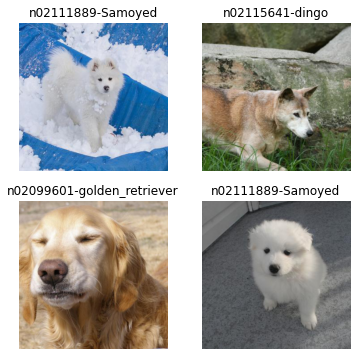

In [31]:
dls = dogs.dataloaders(paths)
dls.valid.show_batch(max_n=4)

Definimos el modelos a entrenar pasandole los dataloaders (train y validation), el modelo y la metrica. (fastai detecta la loss function automaticamente en funcion del problema a resolver)

In [32]:
fs_model = CNN()
learn = Learner(dls, fs_model, metrics=accuracy)

In [33]:
# lr = 0.002
learn.fit(6, lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.955705,2.301287,0.116829,00:16
1,2.998039,2.299268,0.118220,00:16
2,2.686808,2.299265,0.118220,00:16
3,2.538313,2.300488,0.118220,00:16
4,2.454663,2.298964,0.118220,00:16
5,2.403280,2.299262,0.118220,00:17


Se puede ver que los resultados son similares.

## Transfer Learning

Importamos el modelo pre entrenado desde pytorch y cancelamos los gradientes de todas las capas.

In [34]:
from torchvision import models
import copy

alexnet_tl = models.alexnet(pretrained=True)

for param in alexnet_tl.parameters():
    param.requires_grad = False

Revisamos la ultima capa del modelo para redefinirla. Necesitamos que mantenga la cantidad de inputs, pero necesitamos reemplazar la cantidad de outputs (en vez de 1000 por las mil clases de imagenet, necesitamos 10). Al redefirla, esta pasa a ser la unica con parametros entrenables (variables con gradiente).

In [35]:
alexnet_tl.classifier[-1], alexnet_tl.classifier[-1].in_features 

(Linear(in_features=4096, out_features=1000, bias=True), 4096)

In [36]:
num_ftrs = alexnet_tl.classifier[-1].in_features

alexnet_tl.classifier[-1] = nn.Linear(num_ftrs, n_classes)

alexnet_tl = alexnet_tl.to(device)

In [37]:
optimizer_ft = optim.SGD(alexnet_tl.parameters(), lr=0.001, momentum=0.9)

Definimos el loop de entrenamiento:

In [38]:
def train_model_pre(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [39]:
dataloaders_dict = {'train': train_dataloader, 'val': test_dataloader}

In [ ]:
bmodel, val_acc_history = train_model_pre(alexnet_tl, dataloaders_dict, loss_f, optimizer_ft, num_epochs=4)

Epoch 0/3
----------
train Loss: 2.0451 Acc: 0.2849
val Loss: 1.3352 Acc: 0.5806

Epoch 1/3
----------
train Loss: 1.0999 Acc: 0.6762


Otra vez realizamos el mismo proceso pero con fastai para comparar los resultados. 

In [ ]:
learn = cnn_learner(dls, alexnet, metrics=accuracy)

lr = 3e-3
learn.fine_tune(4, lr)